<a href="https://colab.research.google.com/github/flaxoDS/CompletelyNew/blob/master/CIFAR10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transformation: Tensor + Normalisierung für RGB (3 Kanäle)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # für R, G, B
])

# CIFAR-10 Datensatz laden
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoader erstellen
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

# Klassenbezeichnungen (optional für Anzeige)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170M/170M [00:03<00:00, 48.2MB/s]


In [2]:
type(transform)
# <class 'torchvision.transforms.transforms.Compose'>


torchvision.transforms.transforms.Compose

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCIFARCNN(nn.Module):
    def __init__(self):
        super(SimpleCIFARCNN, self).__init__()

        # 1. Convolution: (3, 32, 32) → (16, 30, 30)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)  # Halbiert Höhe/Breite

        # 2. Convolution: (16, 15, 15) → (32, 13, 13)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)

        # Fully connected: 32 * 6 * 6 = 1152
        self.fc1 = nn.Linear(32 * 6 * 6, 64)
        self.fc2 = nn.Linear(64, 10)  # 10 Klassen

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # → (16, 15, 15)
        x = self.pool(F.relu(self.conv2(x)))   # → (32, 6, 6)
        x = x.view(-1, 32 * 6 * 6)              # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
import torch.optim as optim

model = SimpleCIFARCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training
for epoch in range(5):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 1.5111
Epoch 2, Loss: 1.2151
Epoch 3, Loss: 1.0787
Epoch 4, Loss: 0.9909
Epoch 5, Loss: 0.9276


In [5]:
model.eval()  # wichtig: Deaktiviert Dropout etc.
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 66.45%


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


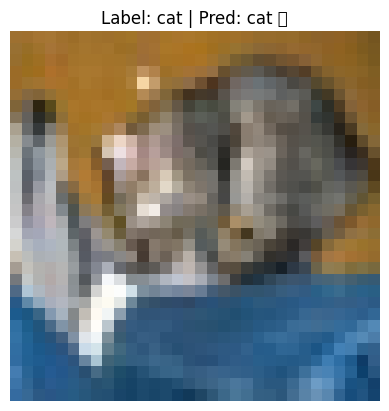

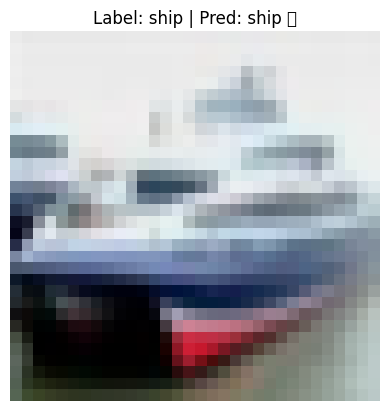

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


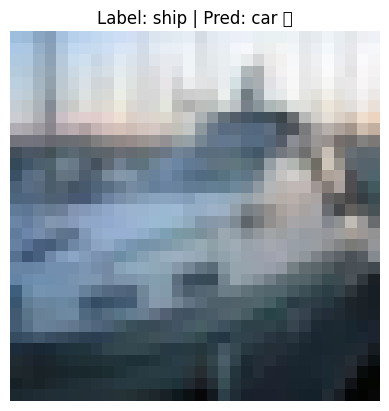

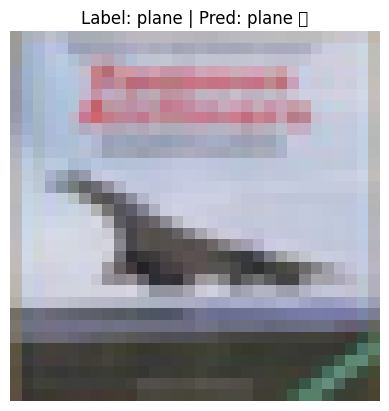

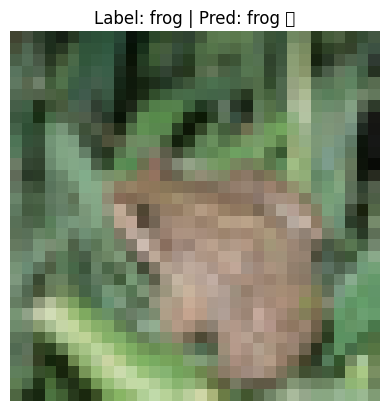

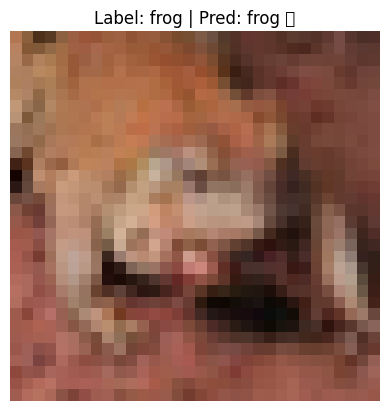

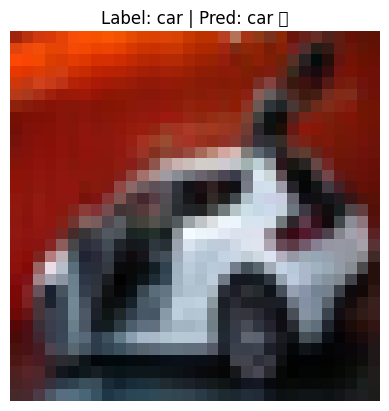

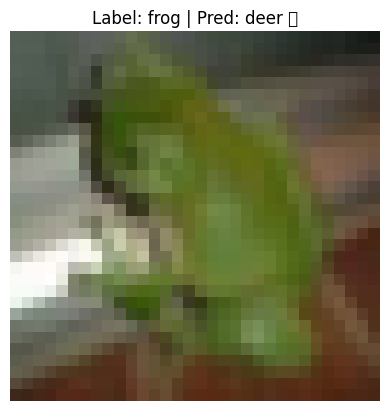

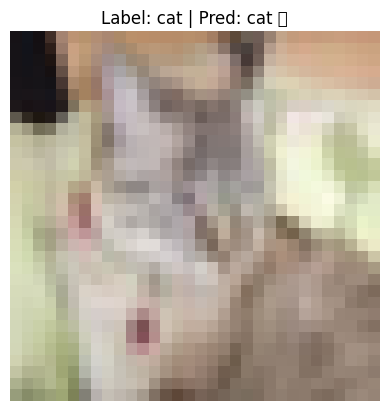

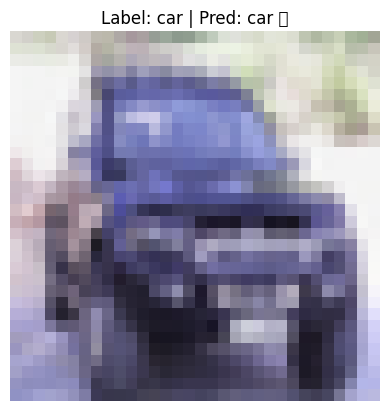

In [6]:
import matplotlib.pyplot as plt
import torchvision

# Hilfsfunktion: zeigt ein einzelnes Bild
def show_image(img, label, prediction=None):
    img = img / 2 + 0.5  # undo Normalize (von [-1, 1] zurück zu [0, 1])
    np_img = img.numpy().transpose((1, 2, 0))
    plt.imshow(np_img)
    title = f"Label: {classes[label]}"
    if prediction is not None:
        title += f" | Pred: {classes[prediction]}"
        if label == prediction:
            title += " ✅"
        else:
            title += " ❌"
    plt.title(title)
    plt.axis("off")
    plt.show()

# Ein paar Bilder aus dem Testset mit Vorhersage anzeigen
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    shown = 0
    for i in range(len(images)):
        if shown >= 10:
            break
        show_image(images[i].cpu(), labels[i].item(), preds[i].item())
        shown += 1


In [7]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.utils as vutils
import torch

# Funktion zur Anzeige eines Bildgrids
def show_grid(images, labels, preds=None, classes=None, nrow=5):
    # Undo Normalize: [-1, 1] → [0, 1]
    images = images * 0.5 + 0.5

    # Grid erzeugen (nrow = Bilder pro Zeile)
    grid_img = vutils.make_grid(images[:nrow * nrow], nrow=nrow)

    # Plot anzeigen
    plt.figure(figsize=(nrow * 2, nrow * 2))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title("Bilder mit Vorhersagen" if preds is not None else "Bilder")
    plt.show()

    # Optional: Einzel-Labels ausgeben
    if preds is not None and classes is not None:
        for i in range(nrow * nrow):
            true = classes[labels[i]]
            pred = classes[preds[i]]
            mark = "✅" if labels[i] == preds[i] else "❌"
            print(f"{i+1:02d}. Label: {true:<8} | Prediction: {pred:<8} {mark}")


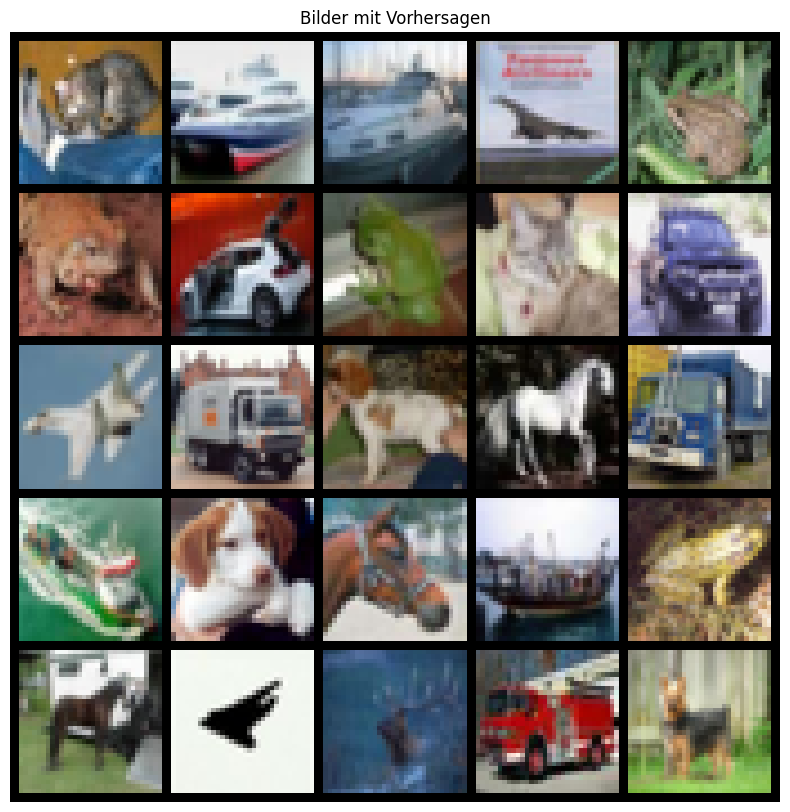

01. Label: cat      | Prediction: cat      ✅
02. Label: ship     | Prediction: ship     ✅
03. Label: ship     | Prediction: car      ❌
04. Label: plane    | Prediction: plane    ✅
05. Label: frog     | Prediction: frog     ✅
06. Label: frog     | Prediction: frog     ✅
07. Label: car      | Prediction: car      ✅
08. Label: frog     | Prediction: deer     ❌
09. Label: cat      | Prediction: cat      ✅
10. Label: car      | Prediction: car      ✅
11. Label: plane    | Prediction: plane    ✅
12. Label: truck    | Prediction: truck    ✅
13. Label: dog      | Prediction: dog      ✅
14. Label: horse    | Prediction: horse    ✅
15. Label: truck    | Prediction: truck    ✅
16. Label: ship     | Prediction: ship     ✅
17. Label: dog      | Prediction: dog      ✅
18. Label: horse    | Prediction: truck    ❌
19. Label: ship     | Prediction: ship     ✅
20. Label: frog     | Prediction: frog     ✅
21. Label: horse    | Prediction: horse    ✅
22. Label: plane    | Prediction: plane    ✅
23. Label:

In [8]:
# Testbatch laden
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    # Grid anzeigen (z. B. 5x5 = 25 Bilder)
    show_grid(images, labels, preds=preds, classes=classes, nrow=5)
